## Dataset Lig-SiO2: ponta revestida com lignina e substrato de dióxido de silício
### Teste 1 - 3x3, `grid_eight`, 100 séries temporais aleatórias.
### Importando bibliotecas e dados

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from matrixprofile import matrixProfile, motifs
from pyclustering.nnet.som import type_conn
import math
import random
import pickle
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


In [6]:
D3011_data = np.load('dataset_TipAu_SiO2.npz')

In [7]:
D3011_data.keys()

KeysView(NpzFile 'dataset_TipAu_SiO2.npz' with keys: verticalTipPosition_m, vDeflection_N, height_m, smoothedMeasuredHeight_m, measuredHeight_m...)

In [8]:
list(D3011_data.keys())

['verticalTipPosition_m',
 'vDeflection_N',
 'height_m',
 'smoothedMeasuredHeight_m',
 'measuredHeight_m',
 'seriesTime_s',
 'time_s']

In [9]:
force_data = D3011_data['vDeflection_N'] * 10**9

In [10]:
force_data.shape

(1024, 800)

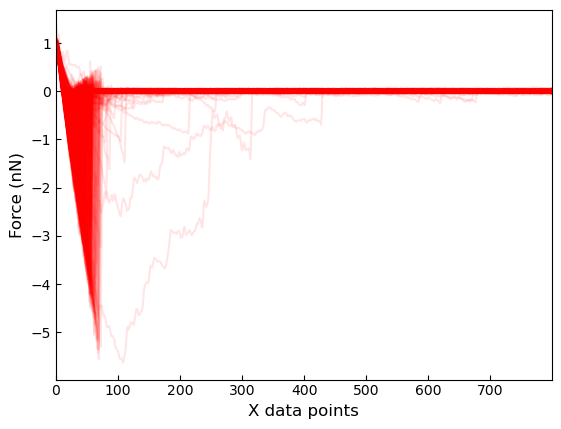

In [11]:
fig,ax = plt.subplots(dpi=100)

for curve in force_data:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Split dos dados

Para essa clusterização, foram selecionados as **primeiras 100 curvas** do *dataset*.

In [12]:
random.seed(1025)
random.shuffle(force_data)

In [13]:
train_set = force_data[:100]
test_set = force_data[100:]

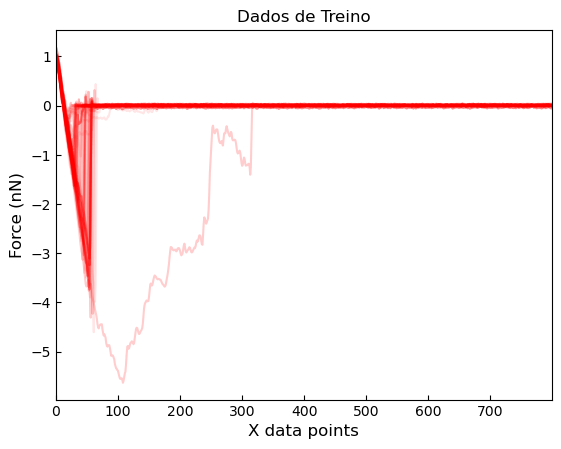

In [14]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

ax.set_title("Dados de Treino")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

In [15]:
len(train_set[0])

800

### Concatenando os dados e descobrindo motifs
Todas as curvas foram concatenadas em uma única série temporal, como indicado no artigo de base, do desenvolvimento do método DTW-SOM.

In [16]:
size = len(train_set[0])
sample_size = len(train_set)
print(size, sample_size)

800 100


In [17]:
joined_data = train_set[0]
for i in range(1, sample_size):
    joined_data = np.concatenate((joined_data, train_set[i]))
len(joined_data)

80000

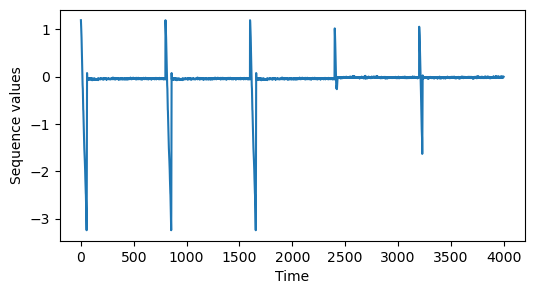

In [18]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(4000), joined_data[:4000])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

In [19]:
%%time
mp = matrixProfile.stomp(joined_data, size)

CPU times: user 41.7 s, sys: 0 ns, total: 41.7 s
Wall time: 41.8 s


In [20]:
print(mp[1])

[  800.   801.   802. ... 31998. 31999. 32000.]


Somando uma matriz de zeros à matriz de perfil, assim, os valores de `Nan` se tornam numéricos e iguais a zero.

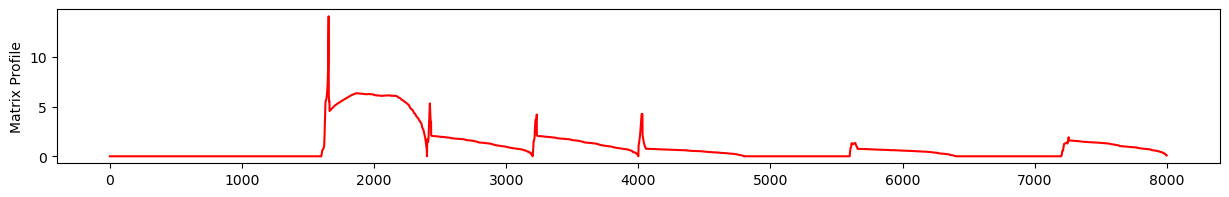

In [21]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(8000), mp_adj[:8000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extraindo os motifs.

In [22]:
%%time
mtfs, motif_d  = motifs.motifs(joined_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 216 ms, sys: 0 ns, total: 216 ms
Wall time: 215 ms


45

Criando uma lista com os centros de motifs.

In [23]:
motif_center_list = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center = joined_data[center_pointers]
    motif_center_list.append(motif_center)

len(joined_data)

80000

In [24]:
len(motif_center_list)

45

### Treinando a rede DTW-SOM

In [21]:
%time
rows = 3
cols = 3
structure = type_conn.grid_eight
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [22]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 2.1182
Epoch 2 achieved an average quantization error of 2.3365
Epoch 3 achieved an average quantization error of 2.2595
Epoch 4 achieved an average quantization error of 2.1973
Epoch 5 achieved an average quantization error of 2.1056
Epoch 6 achieved an average quantization error of 2.0623
Epoch 7 achieved an average quantization error of 2.0326
Epoch 8 achieved an average quantization error of 2.0174
Epoch 9 achieved an average quantization error of 2.0358
Epoch 10 achieved an average quantization error of 2.044
Epoch 11 achieved an average quantization error of 2.0687
Epoch 12 achieved an average quantization error of 2.0735
Epoch 13 achieved an average quantization error of 2.0755
Epoch 14 achieved an average quantization error of 2.0806
Epoch 15 achieved an average quantization error of 2.083
Epoch 16 achieved an average quantization error of 2.0852
Epoch 17 achieved an average quantization error of 2.0862
Epoch 18 achieved an aver

50

In [4]:
# with open("AuSiO2_pkl", "wb") as model:
#     pickle.dump(network, model)
#     model.close()

with open ("AuSiO2_pkl", "rb") as model:
    network = pickle.load(model)

### Resultados

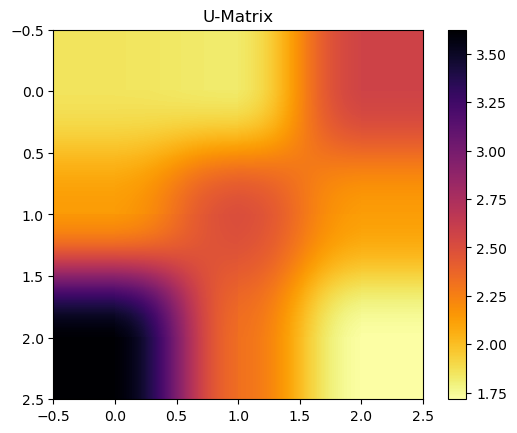

In [24]:
network.show_distance_matrix()

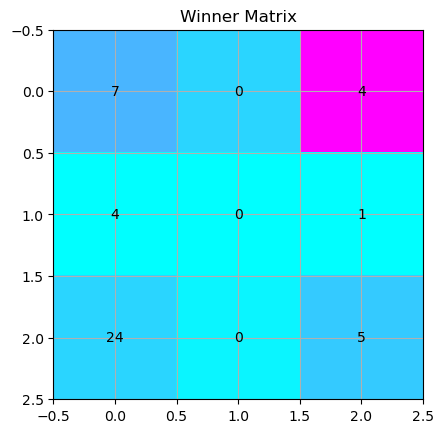

In [25]:
network.show_winner_matrix()

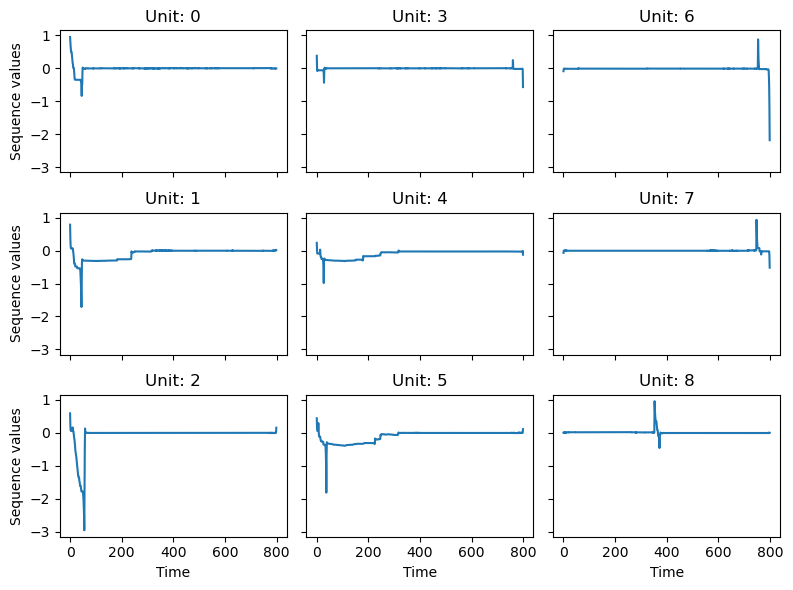

In [26]:
n_neurons = network._size
fig, axs = plt.subplots(3,3,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/3) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 3
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

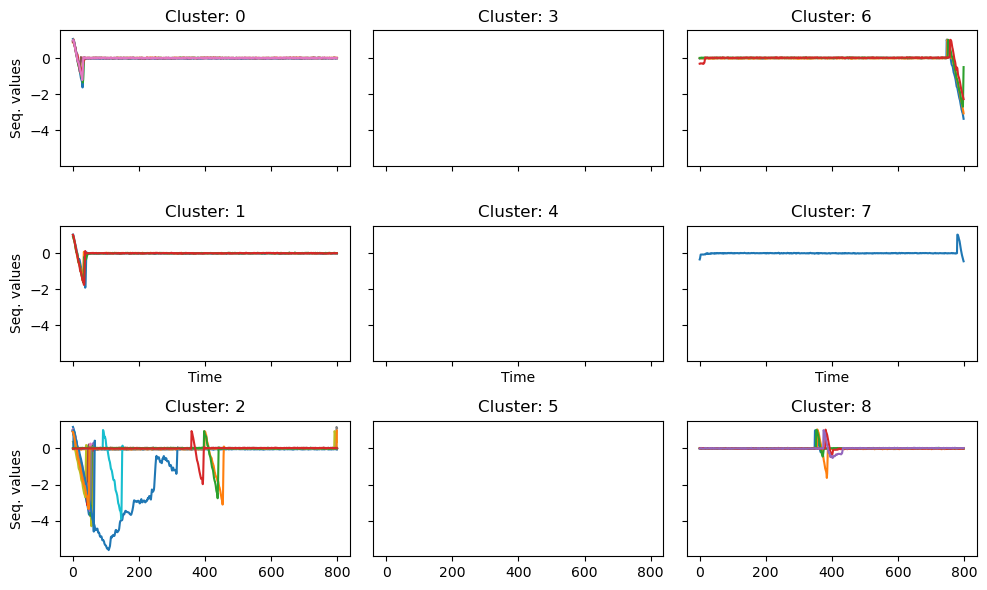

In [27]:
n = rows
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
    axs[row, col].set_title("Cluster: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

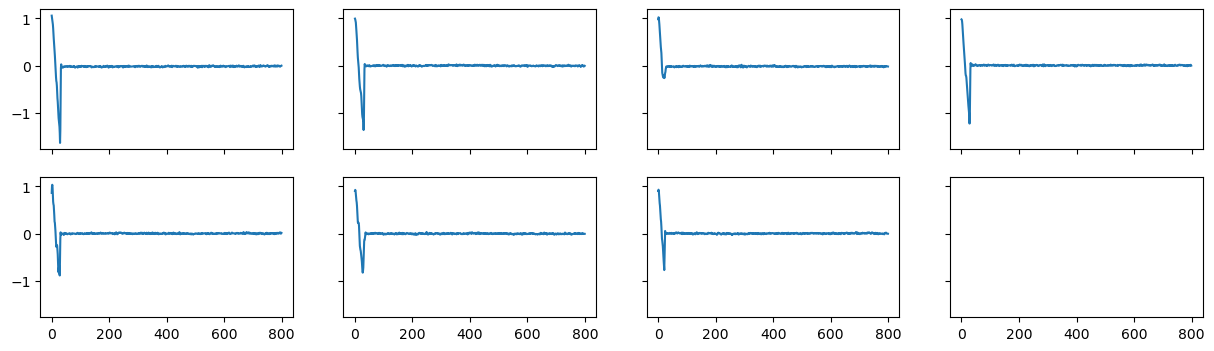

In [25]:
fig, axs = plt.subplots(2, 4,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[0]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

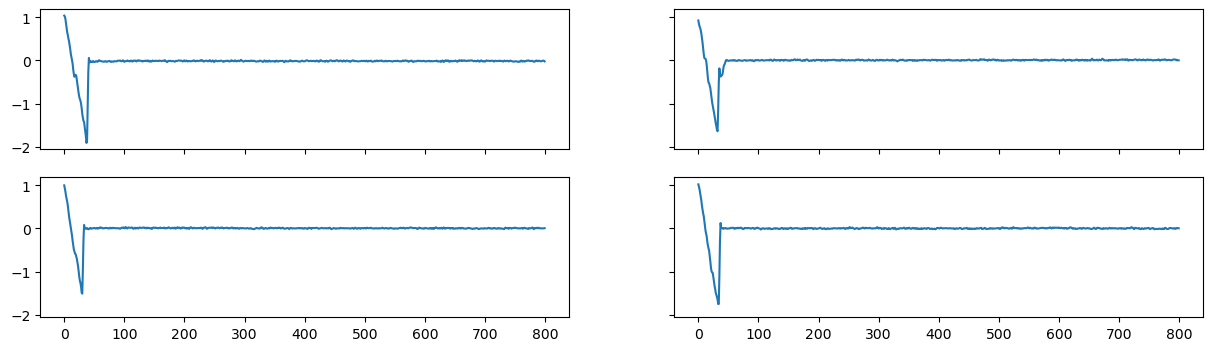

In [26]:
fig, axs = plt.subplots(2, 2,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[1]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

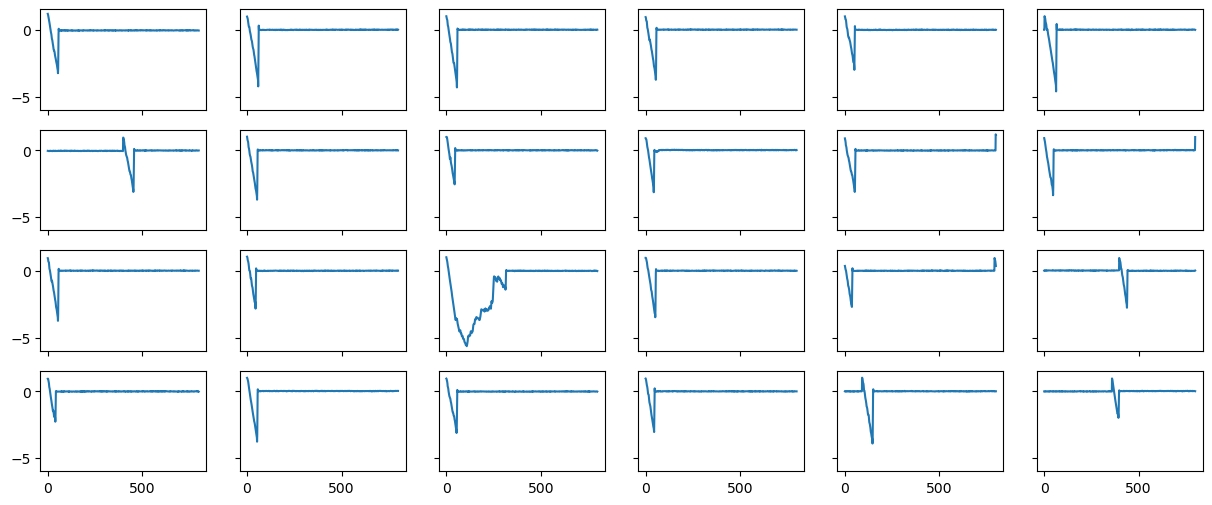

In [27]:
fig, axs = plt.subplots(4, 6,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network.capture_objects[2]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/4)
    row = i % 4
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

In [28]:
def recupera_ts(joined_ts_data, unit, network, mtfs, size, force_data):
    
    id_motifs = network.capture_objects #indices dos motifs em cada unidade
    curvas = []
    motifs = []
    p_mins = []
    
    for i in id_motifs[unit]: #pega o cluster de interesse
        motif = mtfs[i][0] #recupera o indice dos motifs do cluster de interesse
        motifs.append(motif)
    for motif in motifs: #analise o ponto de mínimo de cada motif
        p_min = min(joined_ts_data[motif:motif+size])
        p_mins.append(p_min)
        p_min_index = list(joined_ts_data[motif:motif+size]).index(p_min)
            
        if p_min_index < 100:
            idx_curva = motif // size 
            curvas.append(force_data[idx_curva])
                
        elif p_min_index >= 100 and p_min_index < 150:
            print(f"Duas curvas possíveis no motif {motif}")
            idx_curva_1 = motif // size 
            idx_curva_2 =motif // size + 1
                
            plt.plot(force_data[idx_curva_1], color="r")
            plt.title(f"Série temporal {idx_curva_1} do conjunto de dados")
            plt.xlabel('X data points',fontsize=12)
            plt.ylabel('Force (nN)',fontsize=12)
            plt.show()
                
            plt.plot(force_data[idx_curva_2], color="r")
            plt.title(f"Série temporal {idx_curva_2} do conjunto de dados")
            plt.xlabel('X data points',fontsize=12)
            plt.ylabel('Force (nN)',fontsize=12)
            plt.show()

            best_curve = input("Identifique qual curva melhor se encaixa no cluster de interesse. Insira 1 para a CURVA 1, 2 para a CURVA 2, ou 3 para ambas as curvas.")
                
            while best_curve not in [1,2,3]:
                print("Você deve inserir 1 para a CURVA 1, 2 para a CURVA 2 ou 3 para ambas as curvas.")
                best_curve = int(input("Identifique qual curva melhor se encaixa no cluster de interesse."))
                          
            if best_curve == 1:
                curvas.append([force_data[idx_curva_1]])
            elif best_curve == 2:
                curvas.append([force_data[idx_curva_2]])
            else:
                curvas.append([force_data[idx_curva_1],force_data[idx_curva_2]])
           
        else:
            idx_curva = motif // size + 1 
            curvas.append(force_data[idx_curva])
                
    return curvas, p_mins

In [29]:
curvas0, p_mins0 = recupera_ts(joined_data, 0, network, mtfs, size, force_data)

In [30]:
curvas1, p_mins1 = recupera_ts(joined_data, 1, network, mtfs, size, force_data)

Duas curvas possíveis no motif 12000


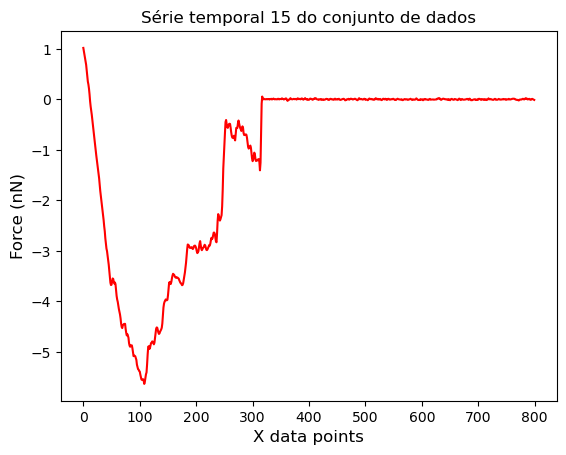

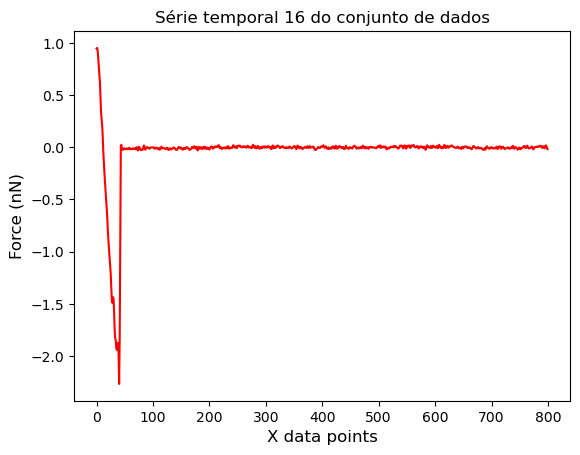

Identifique qual curva melhor se encaixa no cluster de interesse. Insira 1 para a CURVA 1, 2 para a CURVA 2, ou 3 para ambas as curvas. 1


Você deve inserir 1 para a CURVA 1, 2 para a CURVA 2 ou 3 para ambas as curvas.


Identifique qual curva melhor se encaixa no cluster de interesse. 1


Duas curvas possíveis no motif 18309


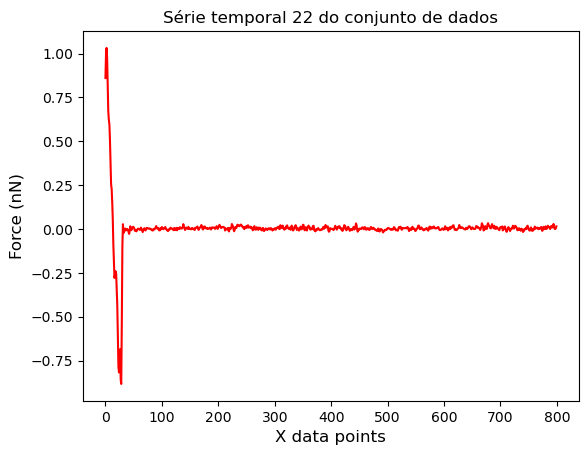

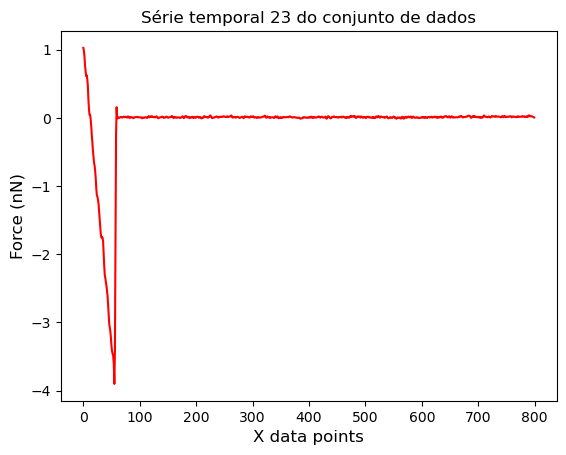

Identifique qual curva melhor se encaixa no cluster de interesse. Insira 1 para a CURVA 1, 2 para a CURVA 2, ou 3 para ambas as curvas. 2


Você deve inserir 1 para a CURVA 1, 2 para a CURVA 2 ou 3 para ambas as curvas.


Identifique qual curva melhor se encaixa no cluster de interesse. 2


In [31]:
curvas2, p_mins2 = recupera_ts(joined_data, 2, network, mtfs, size, force_data)

In [32]:
print(len(curvas0), len(curvas1), len(curvas2))

7 4 24


#### Cluster 0

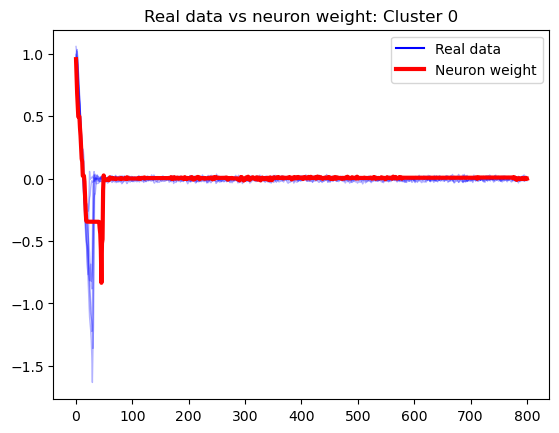

In [33]:
x = np.linspace(0, 800, 800)  # Eixo X

ys_secundarias0 = curvas0

y_principal0 = network.weights[0]

for y0 in ys_secundarias0:
    plt.plot(x, y0, color='blue', linewidth=1, linestyle='-', alpha=0.3)

plt.plot([], [], color="blue", label="Real data")

plt.plot(x, y_principal0, color='red', linewidth=3, label='Neuron weight')
plt.legend()
plt.title("Real data vs neuron weight: Cluster 0")

# Exibir o gráfico
plt.show()

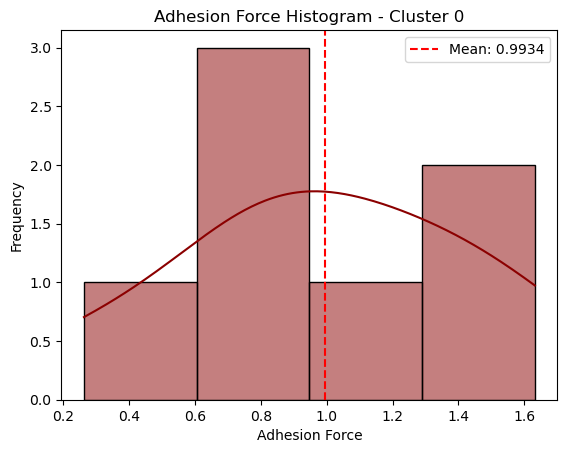

In [59]:
p_mins0 = list(map(lambda x: -x, p_mins0))

eixo = sns.histplot(p_mins0, kde=True, stat="count", color='darkred')

mean_0 = np.mean(p_mins0)

plt.axvline(mean_0, color='r', linestyle='dashed', label=f'Mean: {round(mean_0, 4)}')

plt.legend()
plt.title("Adhesion Force Histogram - Cluster 0")
plt.xlabel("Adhesion Force")
plt.ylabel("Frequency")
plt.show()

#### Cluster 1

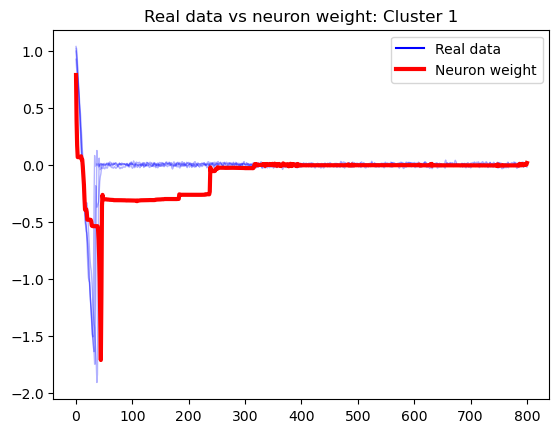

In [41]:
x = np.linspace(0, 800, 800)  # Eixo X

ys_secundarias1 = curvas1

y_principal1 = network.weights[1]

for y1 in ys_secundarias1:
    plt.plot(x, y1, color='blue', linewidth=1, linestyle='-', alpha=0.3)

plt.plot([], [], color="blue", label="Real data")

plt.plot(x, y_principal1, color='red', linewidth=3, label='Neuron weight')
plt.legend()
plt.title("Real data vs neuron weight: Cluster 1")

# Exibir o gráfico
plt.show()

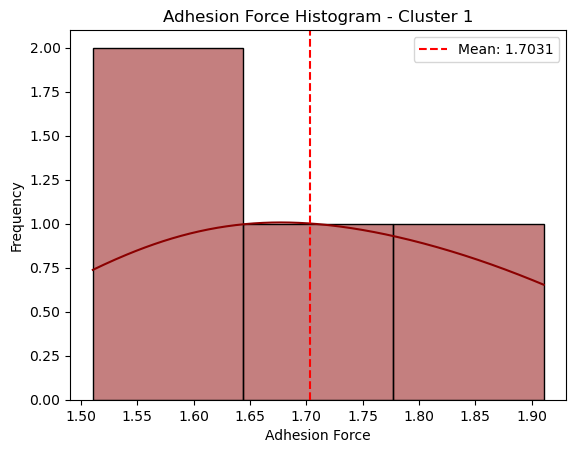

In [58]:
p_mins1 = list(map(lambda x: -x, p_mins1))

eixo = sns.histplot(p_mins1, kde=True, stat="count", color='darkred')

mean_1 = np.mean(p_mins1)

plt.axvline(mean_1, color='r', linestyle='dashed', label=f'Mean: {round(mean_1, 4)}')

plt.legend()
plt.title("Adhesion Force Histogram - Cluster 1")
plt.xlabel("Adhesion Force")
plt.ylabel("Frequency")
plt.show()

#### Cluster 2

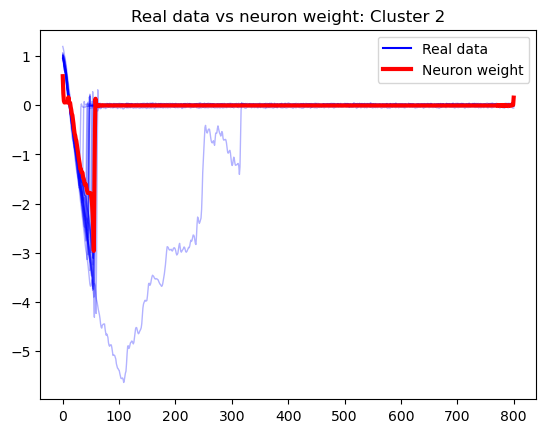

In [44]:
x = np.linspace(0, 800, 800)  # Eixo X

ys_secundarias2 = curvas2

y_principal2 = network.weights[2]

for y2 in ys_secundarias2:
    y2 = np.reshape(y2, (800,))
    plt.plot(x, y2, color='blue', linewidth=1, linestyle='-', alpha=0.3)

plt.plot([], [], color="blue", label="Real data")

plt.plot(x, y_principal2, color='red', linewidth=3, label='Neuron weight')
plt.legend()
plt.title("Real data vs neuron weight: Cluster 2")

# Exibir o gráfico
plt.show()

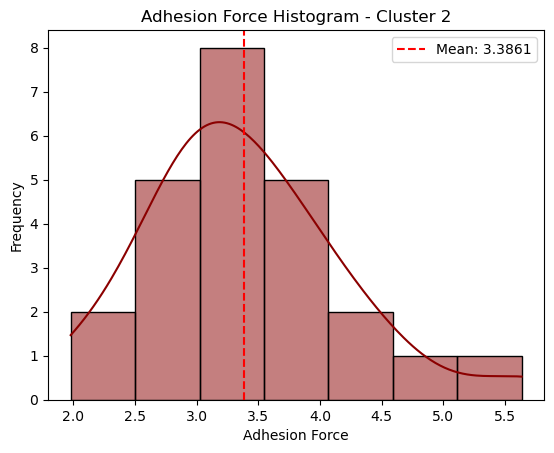

In [57]:
p_mins2 = list(map(lambda x: -x, p_mins2))

eixo = sns.histplot(p_mins2, kde=True, stat="count", color='darkred')

mean_2 = np.mean(p_mins2)

plt.axvline(mean_2, color='r', linestyle='dashed', label=f'Mean: {round(mean_2, 4)}')

plt.legend()
plt.title("Adhesion Force Histogram - Cluster 2")
plt.xlabel("Adhesion Force")
plt.ylabel("Frequency")
plt.show()